# Reproduce PEFT(Parameter-Efficient Fine-Tuning) on Pre-trained Model with Cell Population Discovery
In this tutorial, we demonstrate how to reproduce a PEFT (Parameter-Efficient Fine-Tuning) pre-trained model on a immune dataset for the cell population discovery task. This tutorial serves as a practical example. There are two steps that need to be executed. 

## Step 1: Modify the parameters

### There are four key settings that the reader needs to modify. The available options are listed below:
***dataset_name*** : immune  
***load_model***: {checkpoint_path}/cell_population_discovery  
***data_path***: {data_path}/cell_population_discovery    
***peft_type***: Encoder_adapter/ Token_adapter / Prefix / LoRA / finetune.  


In [1]:
key_parameters = dict(
    dataset_name="immune",  # Dataset name
    load_model="../save/cell_population_discovery",  # Path to peft model
    data_path="../data/cell_population_discovery",
    peft_type="Encoder_adapter",  # Encoder_adapter/ Token_adapter / Prefix / LoRA / finetune
)

In [2]:
import json
import os
from pathlib import Path
import sys
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
from scipy.sparse import issparse
from torch import nn
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
import argparse
from sklearn.metrics import calinski_harabasz_score

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model.model_prompt import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor, TFPreprocessor
from scgpt.utils import set_seed

Global seed set to 0
/users/PCON0022/coffee19850519/ondemand/scPEFT_reproduction/publication/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/ondemand/scPEFT_reproduction/publication/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/ondemand/scPEFT_reproduction/publication/../scgpt/model/model_prompt.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
hyperparameter_defaults = dict(
    seed=42,
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,  # DAR objective weight for batch correction
    mask_ratio=0.4,  # Default mask ratio
    mlm_probability=[0.15, 0.25, 0.4],
    epochs=25,  # Default number of epochs for fine-tuning
    n_bins=51,  # Default number of bins for value binning in data pre-processing
    lr=1e-4,  # Default learning rate for fine-tuning
    batch_size=20,  # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4,  # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,  # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=1,  # Default model evaluation interval
    log_interval=100,  # Default log interval
    fast_transformer=False,  # Default setting
    pre_norm=False,  # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
    num_tokens=20,
    n_layers_conf=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # token
    mlp_adapter_conf=[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    space_adapter_conf=[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    include_zero_gene=False,
    do_batch_classification=False
)

peft_prompt_relationship = {
    "Encoder_adapter": "encoder-prompt",
    "Token_adapter": "head-prompt",
    "Prefix": "prefix-prompt",
    "LoRA": "LoRA",
    "finetune": "finetune"
}

hyperparameter_defaults.update(key_parameters)
config = argparse.Namespace(**hyperparameter_defaults)

config.prompt_type = peft_prompt_relationship[config.peft_type]
config.use_prompt = False if config.prompt_type == "finetune" else True

set_seed(config.seed)

In [4]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 2000  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = False
DSBN = False  # Domain-spec batchnorm
explicit_zero_prob = config.include_zero_gene
include_zero_gene = config.include_zero_gene
do_batch_classification = config.do_batch_classification

dataset_name = config.dataset_name
data_dir = Path(config.data_path)
if dataset_name == 'immune':
    adata = sc.read(data_dir / f"{dataset_name}.h5ad")
    adata.obs["str_batch"] = 0
    adata.obs["celltype"] = adata.obs["annot"]
    data_is_raw = True

# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
if config.load_model is not None:
    model_dir = Path(config.load_model, config.peft_type)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)

    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])

    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)

    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]


In [6]:
# for load TF genes
TF_gene_path = Path(config.load_model, config.peft_type, "TF_names_v_1.01.txt")
with open(TF_gene_path, 'r') as file:
    TF_genes = [line.strip() for line in file.readlines()]
    # Filter not in vocab FT genes
    TF_genes_in_vocab = [TF_gene for TF_gene in TF_genes if TF_gene in vocab]

# set up the preprocessor, use the args to config the workflow
preprocessor = TFPreprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=False,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
    TF_genes=TF_genes_in_vocab,
)

adata = preprocessor(adata, batch_key=None)
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

# For batch correction
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids)) if do_batch_classification else None
batch_ids = np.array(batch_ids)

if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)


scGPT - INFO - Normalizing total counts ...


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Append TF genes to highly variable genes ...


/users/PCON0022/coffee19850519/ondemand/scPEFT_reproduction/publication/../scgpt/preprocess.py:208: ImplicitModificationWarning: Setting element `.layers['X_log1p']` of view, initializing view as actual.
  adata.layers[key_to_process] = np.array(adata.layers[key_to_process])


scGPT - INFO - Binning data ...


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ntokens = len(vocab)  # size of vocabulary

prompt_settings = {
    "use_prompt": config.use_prompt,
    "num_tokens": config.num_tokens,
    "prompt_type": config.prompt_type,
    "n_layers_conf": config.n_layers_conf,
    "mlp_adapter_conf": config.mlp_adapter_conf,
    "space_adapter_conf": config.space_adapter_conf
}

model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=do_batch_classification,  # default is false
    num_batch_labels=num_batch_types,
    use_batch_labels=False,
    n_input_bins=n_input_bins,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    **prompt_settings
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file, map_location=device))
        print(f"Loading all model params from {model_file}")
    except Exception as e:
        traceback.print_exc()
        print(e)

model.to(device)


Loading all model params from ../save/cell_population_discovery/Encoder_adapter/best_model.pt


TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (prompt_dropout): Dropout(p=0, inplace=False)
        (prompt_proj): Identity()
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_featu

In [8]:
def eval_testdata(
        model: nn.Module,
        adata_t: AnnData,
        include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        print("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=include_zero_gene,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings
        CH_Index = calinski_harabasz_score(X=adata_t.obsm["X_scGPT"], labels=adata_t.obs["celltype"])

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[f"CH Index = {CH_Index:.3f}"],
            frameon=False,
            show=True,
        )

        return CH_Index


Evaluating cls cell embeddings


100%|██████████| 1012/1012 [01:09<00:00, 14.65it/s]
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


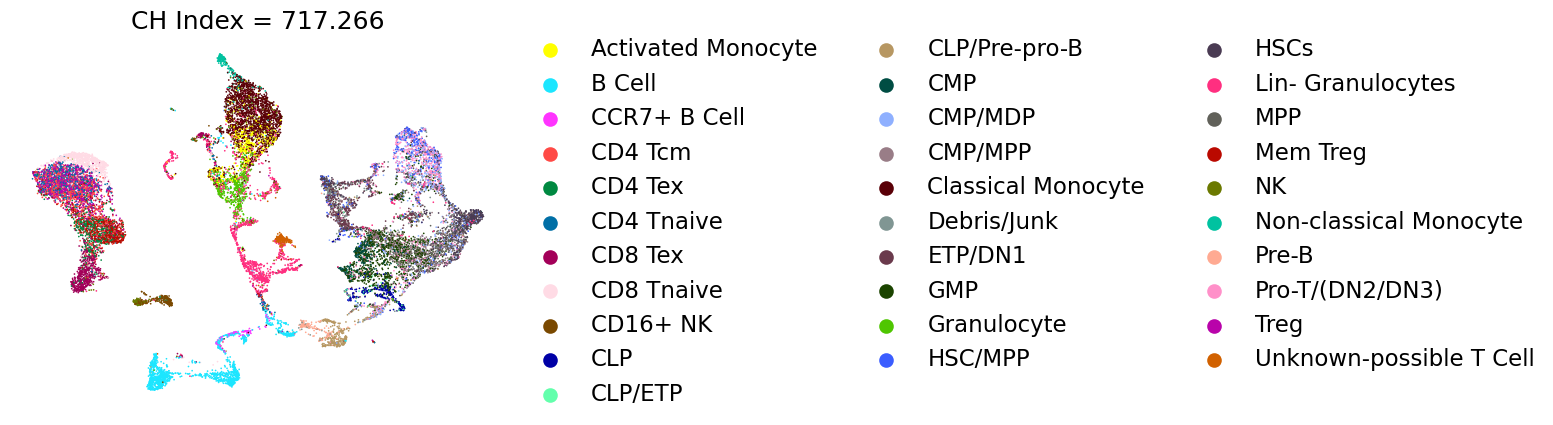

In [9]:
# eval on testdata
result = eval_testdata(
    model,
    adata_t=adata,
    include_types=["cls"],
)